For a Hilbert space truncation $M$ and a detector with $N$ outcomes the m

$$
\min_{\Pi}|| P - F\Pi ||_2 + g(\Pi)
$$

where $F \in \mathbb{R}^{D\times N}$

In [1]:
from math import sqrt, exp, lgamma

from tqdm import tqdm
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, hstack, tensor
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset


from quantum import coherent_ket, lossy_pnr_povm, povm_fidelity, diagonal_povm_fidelity
from loss import phase_insensitive_povm_loss
from utils import check_povm_validity

In [2]:
N = 50  # number of POVM outcomes
M = 5000  # Hilbert space dimension

### True POVMs

In [3]:
def perfect_pnr_povm(hilbert_dim: int, N: int, dtype=th.float64) -> list[th.Tensor]:
    """
    Construct POVMs for a perfect photon-number-resolving detector
    with resolution up to N photons.

    Args:
        hilbert_dim: Dimension of the truncated Fock space.
        N: Maximum resolved photon number (PNR resolution).
        device, dtype: Torch options.

    Returns:
        povms: list of N+1 tensors [Π₀, Π₁, ..., Π_N],
               each (hilbert_dim, hilbert_dim), diagonal.
    """
    povms = [th.zeros((hilbert_dim, hilbert_dim), dtype=dtype) for _ in range(N + 1)]

    for k in range(N):
        if k < hilbert_dim:
            povms[k][k, k] = 1.0  # ideal projection onto |k⟩⟨k|

    # Saturation bin Π_N collects all n >= N
    for n in range(N, hilbert_dim):
        povms[N][n, n] = 1.0

    return povms



def photodetector_povm(hilbert_dim: int, eta: float, dtype=th.float64) -> list[th.Tensor]:
    """
    Returns the POVM elements of a (lossy) on–off photodetector with efficiency `eta`.

    The model follows:
        Π₀ = ∑ₙ (1 - η)ⁿ |n⟩⟨n|     # no-click (missed detection)
        Π₁ = I - Π₀                 # click (at least one photon detected)

    Args:
        hilbert_dim: Hilbert space cutoff (max photon number)
        eta: detection efficiency (0 ≤ η ≤ 1)
        device, dtype: torch settings

    Returns:
        povms: [Π₀, Π₁], each (hilbert_dim, hilbert_dim), diagonal.
    """
    n = th.arange(hilbert_dim, dtype=dtype)
    # Diagonal probabilities
    diag_no_click = (1 - eta) ** n
    diag_click = 1.0 - diag_no_click

    Pi0 = th.diag(diag_no_click)
    Pi1 = th.diag(diag_click)

    return [Pi0, Pi1]


In [4]:
# random POVM
# logits = th.rand((M, N)) - 1  # uniform random range (-1,1)
#  # Rows are probability vectors, rows should sum to 1. 
#  # Column j is the diagonal of povm j.
# true_povm = th.softmax(logits, dim=1).to(dtype=th.float64) 

# PNR detector POVM
true_povm = lossy_pnr_povm(hilbert_dim=M, N=N, eta=1.0)
true_povm = vstack( [th.diagonal(E) for E in true_povm] ).T


# true_povm = photodetector_povm(hilbert_dim=M, eta=0.5)
# true_povm = vstack( [th.diagonal(E) for E in true_povm] ).T



print(f"First row sum is: {sum(true_povm[0, :]).item()}")
print(f"Number of POVM elements: {true_povm.shape[1]}, should be N={true_povm.shape[1]}")
print(f"Shape of Π is: {tuple(true_povm.shape)} should be (M={M}, N={true_povm.shape[1]})")

val_check = [ th.diag(true_povm[:, i]) for i in range(true_povm.shape[1]) ]
print(f'Is true POVM valid? {"Yes" if check_povm_validity(val_check, tol=1e-6) else "No"}')

First row sum is: 1.0
Number of POVM elements: 51, should be N=51
Shape of Π is: (5000, 51) should be (M=5000, N=51)
Is true POVM valid? Yes


### Probe states

In [5]:
D = 500  # D is number of probes
max_amp = sqrt(M) #8. #sqrt(M)/1.5 #sqrt(3.0)   # max coordinate in phase space that will be spanned in one direction is max_amp^2
max_avg = max_amp**2

print(f"Max average photon number will be {max_amp**2:.2} should be < {M//2}.")
#print(f"Is probablitiy condition meet?{ ' Yes' if max_avg**(M)*exp(-max_avg)/exp(lgamma(M+1)) < 10**(-5) else ' No' }")
complex_amps = np.linspace(0, max_amp, D)
# probes = vstack([ coherent_ket(alpha, M) for alpha in complex_amps ])
#probes = probes.abs() ** 2  # we only need the probabilities not the probabilities amplitudes see Eq. 10 in https://doi.org/10.1088/2058-9565/ad8511
probes = tensor(np.array([ poisson.pmf(k=list(range(M)), mu=alpha**2) for alpha in complex_amps ])) 
print(f"Shape of probes is: {tuple(probes.shape)} should be (D={D}, M={M}).")

Max average photon number will be 5e+03 should be < 2500.
Shape of probes is: (500, 5000) should be (D=500, M=5000).


### Target matrix 

In [6]:
targets = probes @ true_povm

print(f"Shape of targets is: {tuple(targets.shape)} should be (D={D}, N={true_povm.shape[1]})")

for i in range(targets.shape[1]):
    if th.sum(targets[0][i]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")


# plot_matrix(
#     targets.numpy()[:5, :5],
#     title="Target Probability Matrix",
#     cmap="viridis",
#     show_values= not False,
#     xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
#     ylabel=r"$|\alpha_i\rangle$",
#     colorbar=True,
#     figsize=(6, 5),
#     vmin=None,
#     vmax=None
# )

Shape of targets is: (500, 51) should be (D=500, N=51)


### Training

In [7]:
lam = 0e-5 # regularization weight NOTE: This is actually detrimental when working with a perfect detector as the regulation is meant for imperfect ones...
current_lr = 0.1  # learning rate
lr_decay = 0.99  # learning rate decay factor
device = 'cuda'

# weight initialization
logits = th.rand((M, true_povm.shape[1])) - 1
logits = logits.to(device)
logits.requires_grad = True


# optimizer = SGD([logits], lr=current_lr, momentum=0.999)
optimizer = Adam([logits], lr=current_lr, betas=(0.9, 0.9))
scheduler = ExponentialLR(optimizer, gamma=lr_decay) # Decay LR by gamma every time called

probes = probes.to(device)
targets = targets.to(device)
dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 25
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
iterations = 50
I = th.eye(2*true_povm.shape[1], dtype=th.complex128).to(device) # identity matrix for retraction step
losses = []
lr_vals = []

for step in tqdm(range(iterations), desc="Learning POVM"):
    lr_vals.append(scheduler.get_last_lr())
    batch_losses = []

    for probes_batch, targets_batch in loader:
        optimizer.zero_grad()

        # Compute batch loss
        L = phase_insensitive_povm_loss(targets_batch, logits, probes_batch, lam)

        L.backward()

        optimizer.step()
        
        batch_losses.append(L.item())
        #current_lr *= lr_decay  # decay learning rate manually

    scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))

Learning POVM: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


Final loss: 8.464150326995935e-06


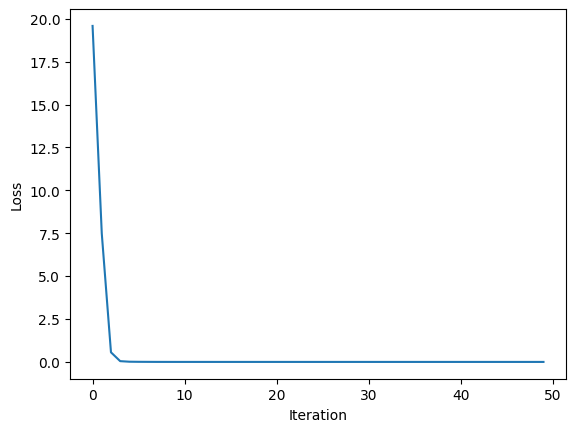

In [9]:
print("Final loss:", losses[-1])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(losses);

In [10]:
# plt.ylabel('Learning rate')
# plt.xlabel('Iteration')
# plt.plot(lr_vals);

In [11]:
with th.no_grad():
    probs = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors
    # pred_povm_full = [ th.diag(probs[:, i]).to('cpu') for i in range(true_povm.shape[1]) ]
    # true_povm_full = [ th.diag(true_povm[:, i]) for i in range(true_povm.shape[1]) ]

    # print(f'Is predicted POVM valid? {"Yes" if check_povm_validity(pred_povm_full, tol=1e-5) else "No"}')

    Fs = [ diagonal_povm_fidelity(th.diag(probs[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    print("Fidelities: ", Fs)
    print(f"Mean fidelity is {sum(Fs)/len(Fs)}")

Fidelities:  [0.9895035518024433, 0.9894552550548703, 0.9892898085342348, 0.9891564176275361, 0.9888526618035961, 0.9886442236028002, 0.9881508187826071, 0.9877749645044638, 0.9868931117147669, 0.985836413931116, 0.9845128937425878, 0.9839407205388023, 0.9815985592135941, 0.9793533541907236, 0.9771209399963149, 0.9789343830431456, 0.9778857067790195, 0.9675986580639301, 0.952418497648735, 0.9479855904856368, 0.9580816191405378, 0.9709993543832995, 0.9695812943014424, 0.9651095946145826, 0.9618104078547931, 0.9547166520475563, 0.9580934777627186, 0.9650824648987452, 0.9642411846992448, 0.9650888645301136, 0.9521513836702998, 0.9064770129369213, 0.8736523216267849, 0.8922837475032994, 0.9441302031188978, 0.9082608035992756, 0.8683355730177734, 0.8094814539526418, 0.6520253628667768, 0.5283137503924511, 0.5532774498530978, 0.3470362632889709, 0.40652460470212237, 0.7102081933423643, 0.717517138530243, 0.7924982842730037, 0.8915049885464984, 0.9243075125738963, 0.9388080944845812, 0.969420

In [12]:
# trunc_n = min(30, logits.shape[1])
# plt.plot(list(range(trunc_n)), [1-F for F in Fs[:trunc_n]], label=rf"$\lambda$={lam}")  # get infidelities

# plt.legend()
# plt.yscale("log")
# plt.ylabel(r"Infidelity $F'_n$")
# plt.xlabel(r"Outcome $n$");

In [ ]:
import cvxpy as cp

def optimize_phase_insensitive_povm(targets, probes, lam=0.1):
    """
    Solve convex relaxation of phase-insensitive POVM loss using CVXPY.
    D = num_probes, N = number of POVM elements (outcomes), M = Hilbert dim
    
    Args:
        targets: (D, N) numpy array — target probabilities
        probes: (D, M) real numpy array — probe state Fock probabilities
        lam: regularization coefficient
    """

    _, M = probes.shape
    N = targets.shape[1]

    # Variables: POVM diagonals (each column = diagonal of one POVM element)
    Pi = cp.Variable((M, N), nonneg=True)

    # Normalization constraint: sum over all POVM elements = I (each ROW (axis=1) sums to 1)
    constraints = [cp.sum(Pi, axis=1) == 1]

    # Predicted probabilities: p[m, b] = |ψ_b|^2 ⋅ Π_m
    pred_probs = probes @ Pi   # shape (num_probes, M)

    # Loss term
    sq_err = cp.sum_squares(pred_probs - targets)

    # Regularization term (smoothness across consecutive POVM elements)
    reg = cp.sum_squares(Pi[:-1, :] - Pi[1:, :])

    # Objective
    objective = cp.Minimize(sq_err + lam * reg)

    # Problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK, verbose=False)  # use MOSEK solver as in arXiv:2306.12622v1 or splitting conic solver (SCS)

    return Pi.value, prob.value


: 

In [ ]:
Pi, prob = optimize_phase_insensitive_povm(targets.cpu().numpy(), probes.cpu().numpy(), lam)

In [ ]:
print(f"Shape of Π is: {tuple(th.tensor(Pi).shape)} should be (M={M}, N={true_povm.shape[1]}).") 

Shape of Π is: (5000, 21) should be (M=5000, N=21).


In [ ]:
# pred_povm_full = [ th.diag(tensor(Pi[:, i])) for i in range(true_povm.shape[1]) ]
# true_povm_full = [ th.diag(true_povm[:, i]) for i in range(true_povm.shape[1]) ]
# print(f'Is predicted POVM valid? {"Yes" if check_povm_validity(pred_povm_full, tol=1e-6) else "No"}')

Fs = [ diagonal_povm_fidelity(tensor(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
print("Fidelities: ", Fs)
print(f"Mean fidelity is {sum(Fs)/len(Fs)}")

Fidelities:  [0.9777475513415633, 0.9777392941644643, 0.9777227190094983, 0.9777004079877376, 0.977673799010829, 0.9776463435347806, 0.977617511889938, 0.9775865361971026, 0.9775516041488896, 0.9775115933813203, 0.9774664408132904, 0.9774174087894301, 0.977367698184134, 0.977320777100695, 0.9772800689440562, 0.9772511090751296, 0.9772410625372709, 0.9772550215730086, 0.9773141985340524, 0.9774317981469157, 0.9999999435334462]
Mean fidelity is 0.9785639470427407


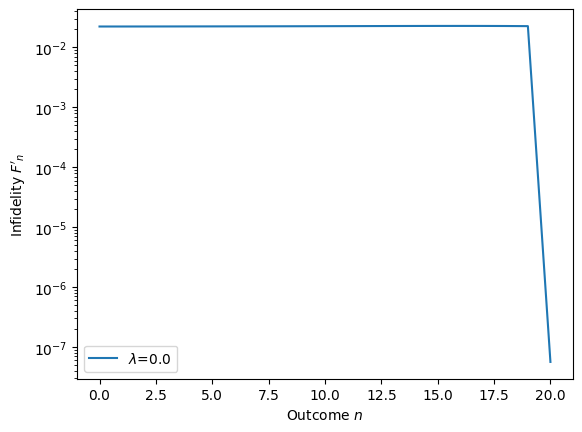

In [ ]:
trunc_n = min(30, Pi.shape[1])
plt.plot(list(range(trunc_n)), [1-F for F in Fs[:trunc_n]], label=rf"$\lambda$={lam}")  # get infidelities

plt.legend()
plt.yscale("log")
plt.ylabel(r"Infidelity $F'_n$")
plt.xlabel(r"Outcome $n$");